# Experimental TD-FLIM Analysis & MSSR Enhancement

### Overview
This notebook implements a pipeline for analyzing *experimental Time-Domain FLIM* data. It focuses on the phasor approach to Lifetime Imaging and evaluates the impact of *Mean Shift Super Resolution (MSSR)* on phasor data quality.

The core hypothesis is that spatial super-resolution (MSSR) applied to the intensity image provides a superior segmentation mask. This allows us to reject background noise and mixed pixels more effectively than standard diffraction-limited intensity thresholding, leading to tighter clusters and better separation in the phasor plot.

### Workflow

1. Data Ingestion:
  * Load experimental TCSPC data (Sample vs. Reference).
  * Extract photon arrival histograms ($x, y, t$).
2. Phasor Transformation & Calibration:
  * Convert time-domain decays to phasor coordinates ($G, S$).
  * Calibration: Use a reference standard to correct for the instrument response function (IRF) and system delays.
3. Preprocessing: Apply median filtering to the phasor components to reduce salt-and-pepper noise while preserving edges.
4. Standard Analysis (Baseline):
  * Threshold phasor data based on the original confocal intensity.
  * Perform ROI selection using circular cursors.
  * Calculate baseline metrics: Phasor dispersion (Ellipse Area), Anisotropy, and Centroid position.
5. MSSR Enhancement:
  * Apply the MSSR algorithm to the intensity image to generate a super-resolved map.
  * Re-threshold the phasor data using this new MSSR-sharpened mask.
6. Quantitative Comparison:
  * Compare the phasor distributions (Before vs. After MSSR).
  * Quantify improvements using metrics: **Cluster Shrinkage** (Area Ratio), **Orientation Change**, and **Fractional Separation**.

In [1]:
# Install Libraries
# Uncomment to install phasorpy and ptufile
print("Installing necessary libraries...")

!pip install cmcrameri
# Install PhasorPy (specifically version 0.7)
!python -m pip install -U "phasorpy==0.7"
# Install PTU file reader
!pip install ptufile > /dev/null 2>&1
!pip install PyQt5 > /dev/null 2>&1
# Install Napari and MSSR plugin
print('Wait another minute, patience is key... "Life is what happens when installing Python libraries"')

!pip install napari[all] > /dev/null 2>&1
!pip install git+https://github.com/RoccoDAnt/napari-superres.git > /dev/null 2>&1
print("Libraries installed successfully.")

Installing necessary libraries...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.4/277.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 48.4 MB/s eta 0:00:00
Wait another minute, patience is key... "Life is what happens when installing Python libraries"
Libraries installed successfully.


### Mount Google Drive

This step is only required to access local or cloud-stored data files when running the notebook in Google Colab.  
All data used in this study are publicly available via the Zenodo repository (see *Data Availability* section).


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Libraries

import matplotlib.pyplot as plt
#libraries for the Scale bar
import matplotlib.patches as patches
import matplotlib.colors as colors

#libraries for the phasor plot and phasor analysis
import phasorpy
from phasorpy.datasets import fetch
from phasorpy.io import signal_from_ptu, lifetime_from_lif, phasor_from_lif
#from phasorpy.filter import phasor_filter_median                                                                       # Uncomment when using PhasorPy 0.8
from phasorpy.plot import plot_signal_image, plot_phasor_image, plot_phasor, PhasorPlot
from phasorpy.phasor import phasor_from_signal, phasor_threshold, phasor_filter_median                                  # phasor_filter_median has been moved to phasorpy.filter in 0.8 version
from phasorpy.lifetime import lifetime_to_signal, phasor_calibrate, phasor_from_lifetime, phasor_to_apparent_lifetime
from phasorpy.cursor import mask_from_circular_cursor, mask_from_elliptic_cursor, mask_from_polar_cursor, pseudo_color
from phasorpy.color import CATEGORICAL

#library for MSSR
from napari_superres.core_mssr import mssr_class
mssr_instance = mssr_class()

# Libraries for computing phasor metrics
from scipy.linalg import eigh
import math
from scipy.spatial.distance import jensenshannon
from sklearn.metrics import auc
from scipy.ndimage import gaussian_filter1d
from scipy.stats import entropy, ks_2samp, linregress
from scipy.signal import find_peaks
from scipy.signal import savgol_filter

# Redefine the PhasorPlot class with the modified hist2d method
from typing import Any, Union
from numpy.typing import ArrayLike

# Colorbar customization for the my_hist2d function

from mpl_toolkits.axes_grid1 import make_axes_locatable

#additional libraries
import cmcrameri.cm as cmc
import numpy as np

#Tiff file
import tifffile

This exception is what's causing cl equals None: clGetPlatformIDs failed: PLATFORM_NOT_FOUND_KHR


/usr/local/lib/python3.12/dist-packages/liquid_engine/__opencl__.py:125: UserWarning: tap... tap... tap... COMPUTER SAYS NO (OpenCL)!
  warnings.warn("tap... tap... tap... COMPUTER SAYS NO (OpenCL)!")


Cupy implementation is not available. Make sure you have the right version of Cupy and CUDA installed.
Optional dependecy Dask_image is not installed. Implementations using it will be ignored.


#### Define Helper Functions

* plot_histograms: Utility for plotting 1D histograms.
* phasor_centroid_and_cov: Calculates the center of mass and covariance matrix of a phasor cloud.
* confidence_ellipse_params: Derives the dimensions (a, b) and area of the 95% confidence ellipse.
* compute_phasor_metrics: Wrapper to calculate and print comparison metrics (Before vs. After MSSR).

In [4]:
# =========================
# Figure Formatting Parameters
# =========================
fontsize = 30
labelsize = 28
ticksize = 24
legendsize = 18

lw = 3        # linewidth of phasor semicircle
n_bin = 200   # bins for 2D histograms

# =========================
# Helper Functions
# =========================
def plot_histograms(
    *data,
    title=None,
    xlabel=None,
    ylabel=None,
    labels=None,
    show=True,
    title_fontsize = 18,
    label_fontsize=16,
    tick_labelsize=14,
    legend_fontsize=14,
    density=False,  # Added density parameter
    **kwargs,
) -> None:
  """Plot histograms of flattened data arrays.

  Parameters
  ----------
  data: array_like
      Data arrays to be plotted as histograms.
  title : str, optional
      Figure title.
  xlabel : str, optional
      Label for x-axis.
  ylabel : str, optional
      Label for y-axis.
  labels: sequence of str, optional
      Labels for each data array.
  show : bool, optional, default: True
      Display figure.
  density : bool, optional, default: False
      Normalize the histogram such that the integral over the range is 1.
  **kwargs
      Additional arguments passed to :func:`matplotlib.pyplot.hist`.

  """
  ax = plt.subplots()[1]
  if kwargs.get('alpha') is None:
      ax.hist(
          [np.asarray(d).flatten() for d in data], label=labels, density=density, **kwargs # Added density
      )
  else:
      for d, label in zip(
          data, [None] * len(data) if labels is None else labels
      ):
          ax.hist(np.asarray(d).flatten(), label=label, density=density, **kwargs) # Added density
  if title is not None:
      ax.set_title(title, fontsize=title_fontsize)
  if xlabel is not None:
      ax.set_xlabel(xlabel, fontsize = label_fontsize)
  if ylabel is not None:
      ax.set_ylabel(ylabel, fontsize = label_fontsize)
  if labels is not None:
      ax.legend(fontsize=legend_fontsize)
  #Tick size
  ax.tick_params(axis='both', which='major', labelsize=tick_labelsize)

  plt.tight_layout()
  if show:
      plt.show()

# Functions to compute phasor and fraction plots' metrics

def phasor_centroid_and_cov(G, S, mask=None):
  """
  Computes the centroid (mean G, mean S) and the covariance matrix
  of the phasor distribution. Used to determine the center and
  spread (dispersion) of the cloud.
  """
  G = np.array(G, dtype=float)
  S = np.array(S, dtype=float)

  # Apply mask if provided (e.g., MSSR threshold mask)
  if mask is not None:
      mask = np.array(mask, dtype=bool)
      G = G[mask]
      S = S[mask]
  else:
      G = G.ravel()
      S = S.ravel()

  # Filter invalid values
  valid = np.isfinite(G) & np.isfinite(S)
  G = G[valid]
  S = S[valid]

  if G.size == 0:
      return (np.nan, np.nan), np.full((2, 2), np.nan), 0

  pts = np.vstack([G, S])
  centroid = np.mean(pts, axis=1)
  cov = np.cov(pts)

  return (centroid[0], centroid[1]), cov, len(G)


# =========================
# Confidence Ellipse Metrics
# =========================
def confidence_ellipse_params(cov, confidence=0.95):
    """
    Calculates the geometry of the confidence ellipse based on the
    covariance matrix.

    Returns
    -------
    a : float
        Major axis length
    b : float
        Minor axis length
    area : float
        Ellipse area
    anisotropy : float
        Ratio a / b
    """
    chi2 = {
        0.68: 2.279,
        0.95: 5.991,
        0.99: 9.21,
    }.get(confidence, 5.991)

    if np.any(np.isnan(cov)):
        return np.nan, np.nan, np.nan, np.nan

    # Eigenvalues represent variance along principal axes
    vals, _ = eigh(cov)
    vals = np.sort(vals)

    a = np.sqrt(vals[1] * chi2)  # Major axis
    b = np.sqrt(vals[0] * chi2)  # Minor axis

    area = np.pi * a * b
    anisotropy = a / b if b > 0 else np.nan

    return a, b, area, anisotropy

def ellipse_orientation(cov):
    """
    Compute orientation of the ellipse (in radians) from covariance matrix.
    Returns angle of the major axis with respect to the G-axis.
    """
    if np.any(np.isnan(cov)):
        return np.nan
    sigma_GG = cov[0, 0]
    sigma_SS = cov[1, 1]
    sigma_GS = cov[0, 1]
    theta = 0.5 * np.arctan2(2 * sigma_GS, sigma_GG - sigma_SS)
    return theta  # radians

# =========================
# Phasor Distribution Metrics
# =========================
def compute_phasor_metrics(
    G_before,
    S_before,
    G_after,
    S_after,
    mask=None,
):
    """
    Compare phasor distributions before and after processing (e.g., MSSR).

    Computes:
    - Ellipse area (before / after)
    - Area ratio (shrinkage)
    """
    results = {}

    # Before MSSR
    cent_b, cov_b, n_b = phasor_centroid_and_cov(G_before, S_before, mask)
    a_b, b_b, area_b, aniso_b = confidence_ellipse_params(cov_b)
    theta_b = ellipse_orientation(cov_b)

    # After MSSR
    cent_a, cov_a, n_a = phasor_centroid_and_cov(G_after, S_after, mask)
    a_a, b_a, area_a, aniso_a = confidence_ellipse_params(cov_a)
    theta_a = ellipse_orientation(cov_a)

    # Metrics
    displacement = math.hypot(cent_a[0] - cent_b[0], cent_a[1] - cent_b[1])
    area_ratio = area_a / area_b if (area_b and area_b > 0) else np.nan
    aniso_ratio = aniso_a / aniso_b if (aniso_b and np.isfinite(aniso_b)) else np.nan
    dtheta = (theta_a - theta_b) * 180 / np.pi  # in degrees

    results.update({
        "n_points_before": n_b,
        "n_points_after": n_a,
        "centroid_before": cent_b,
        "centroid_after": cent_a,
        "centroid_displacement": displacement,
        "ellipse_area_before": area_b,
        "ellipse_area_after": area_a,
        "area_ratio": area_ratio,
        "anisotropy_before": aniso_b,
        "anisotropy_after": aniso_a,
        "anisotropy_ratio": aniso_ratio,
        "covariance_before": cov_b,
        "covariance_after": cov_a,
        "sigma_GS_before": cov_b[0,1],
        "sigma_GS_after": cov_a[0,1],
        "orientation_before_deg": theta_b * 180 / np.pi,
        "orientation_after_deg": theta_a * 180 / np.pi,
        "orientation_change_deg": dtheta
    })

    # --- Print results ---
    print("\n--- Phasor Metrics ---")
    for k, v in results.items():
        if isinstance(v, (float, np.floating)):   # format floats to 4 decimals
            print(f"{k:25s}: {v: .4f}")
        elif isinstance(v, (tuple, list)) and all(isinstance(x, (float, np.floating)) for x in v):
            formatted = ", ".join([f"{x:.4f}" for x in v])
            print(f"{k:25s}: ({formatted})")
        else:  # integers or other types
            print(f"{k:25s}: {v}")

    return results

# =========================
# Fraction Distribution Metrics
# =========================

def compute_fraction_metrics(
    fractions,
    y_before,
    y_after,
    window_length=11,
    polyorder=3,
    n_permutations=1000
):
    """
    Compute metrics comparing two normalized fraction histograms (before/after MSSR).
    Includes detection of the inflection point (f*) and slope at that point.

    Parameters
    ----------
    fractions : 1D array
        Fraction values (x-axis).
    y_before : 1D array
        Normalized histogram counts before MSSR.
    y_after : 1D array
        Normalized histogram counts after MSSR.
    window_length : int
        Length of the Savitzky-Golay filter window for smoothing.
    polyorder : int
        Polynomial order for smoothing.
    n_permutations : int
        Number of random permutations for permutation test.

    Returns
    -------
    dict
        Dictionary of all computed metrics.
    """

    # Ensure numpy arrays and handle NaNs
    fractions = np.asarray(fractions)
    y_before = np.nan_to_num(np.asarray(y_before), nan=0.0)
    y_after = np.nan_to_num(np.asarray(y_after), nan=0.0)

    # Normalize histograms to sum = 1
    y_before /= np.sum(y_before)
    y_after /= np.sum(y_after)

    # Smooth for derivative estimation
    yb = savgol_filter(y_before, window_length, polyorder)
    ya = savgol_filter(y_after, window_length, polyorder)

    # Basic metrics
    var_before = np.var(yb)
    var_after = np.var(ya)

    # Overlap coefficient
    overlap = np.sum(np.minimum(yb, ya))

    # Jensen-Shannon divergence
    m = 0.5 * (yb + ya)
    jsd = 0.5 * (entropy(yb, m) + entropy(ya, m))

    # Derivative to find inflection points
    dyb = np.gradient(yb, fractions)
    dya = np.gradient(ya, fractions)

    # Find inflection (maximum |slope|)
    idx_b = np.argmin(dyb)
    idx_a = np.argmin(dya)

    f_star_before = fractions[idx_b]
    f_star_after = fractions[idx_a]
    slope_before = dyb[idx_b]
    slope_after = dya[idx_a]
    delta_f_star = f_star_after - f_star_before

    # FWHM estimation
    half_max_before = np.max(yb) / 2
    half_max_after = np.max(ya) / 2
    fwhm_before = np.sum(yb > half_max_before) / len(yb)
    fwhm_after = np.sum(ya > half_max_after) / len(ya)

    # KS test
    ks_stat, ks_p = ks_2samp(yb, ya)

    # Permutation test (simplified, compares overlap)
    overlaps = []
    for _ in range(n_permutations):
        np.random.shuffle(y_after)
        overlaps.append(np.sum(np.minimum(yb, y_after)))
    perm_p = np.mean(np.array(overlaps) <= overlap)

    # Collect metrics
    metrics = {
        "variance_before": var_before,
        "variance_after": var_after,
        "overlap_coefficient": overlap,
        "JSD": jsd,
        "f_star_before": f_star_before,
        "f_star_after": f_star_after,
        "delta_f_star": delta_f_star,
        "slope_before": slope_before,
        "slope_after": slope_after,
        "FWHM_before": fwhm_before,
        "FWHM_after": fwhm_after,
        "KS_statistic": ks_stat,
        "KS_p_value": ks_p,
        "permutation_p_value": perm_p,
    }

    # Print neatly
    print("\n--- Fraction Metrics ---")
    for k, v in metrics.items():
        print(f"{k:20s}: {v: .6e}")

    return metrics

# =========================
# Custom PhasorPlot Extension
# =========================
class PhasorPlot(PhasorPlot):
    def my_hist2d(self, real, imag, /, **kwargs):
        """
        Custom 2D histogram plotter supporting LogNorm
        and specific colormaps.
        """
        my_kwargs = {
            k: kwargs.pop(k)
            for k in ["bins", "range", "density"]
            if k in kwargs
        }

        # Filter NaNs
        mask = (
            np.isfinite(real.flatten())
            & np.isfinite(imag.flatten())
        )

        h, xedges, yedges = np.histogram2d(
            real.flatten()[mask],
            imag.flatten()[mask],
            **my_kwargs,
        )

        # Plot using pcolormesh
        pcolormesh_kwargs = {
            "cmap": "Blues",
            "norm": "log",
        }
        pcolormesh_kwargs.update(kwargs)

        mappable = self._ax.pcolormesh(
            xedges,
            yedges,
            h.T,
            **pcolormesh_kwargs,
        )

        return mappable

In [5]:
## Figure formatting

#Font format
fontsize = 30
labelsize = 28
ticksize = 24
legendsize = 18

# Linewidth of graphs
lw = 3                              # linewidth of phasor semicircle
lw_plot = 2.5                       # linewidth of graphic lines
lw_cursor = 3                       # linewidth of cursors

#colors and cmaps
sc_color = 'k'                      # color for the semicircle (black)
cmap_ph = 'cmc.vanimo_r'            # cmap for phasor plot
intensity = 'gray'                  # cmap for intensity image
tag_color = 'dimgray'               # color for the component graph and labels
cmap_c = 'Purples_r'                # cmap for contour plot

#Phasor parameters

n_bin = 200     #number of bins for Phasor Plot 2D histograms

# Axes limits for zoomed phasor plot
xlim=(0.29, 1.015)
ylim=(0.2,0.63)

## Data Ingestion
We load the experimental data.
* Sample: A DNA-PAINT experiment (Series009_seq1.ptu).
* Reference: A homogeneous solution of Atto 488 (ATTO488_200nM_LaserPower10_10LineRep_10FrameAccum_80MHz[1].ptu) used for calibration.
Note: The code sums/averages the time frames to create a high-SNR 2D image for analysis.

In [6]:
# =========================
# Define File Paths
# =========================
# DNA-PAINT experiment
img_data = (
    "/content/drive/MyDrive/MSSR-FLIM/Data/GATTA_IVAN/wetransfer_datos-flim-icfo-ivancoto_2025-06-06_0737/20250529/Image1_50accum_0p2laserpower_100Hz_80nm_channel1_524to651nm.sptw/Series009_seq1.ptu"
)

# Solution of Atto 488
ref_data = (
    "/content/drive/MyDrive/MSSR-FLIM/Data/ICFO/ATTO488 (reference)/80MHz/ATTO488_200nM_LaserPower10_10LineRep_10FrameAccum_80MHz[1].ptu"
)

# =========================
# Load Sample Data
# =========================
# Option 1: Load all frames and average for better SNR
#signal = signal_from_ptu(img_data)
#mean_signal = np.mean(signal, axis=0)

# Option 2: Analyze a single frame (used for this run)
signal = signal_from_ptu(img_data, frame=0)

# Extract laser repetition frequency (typically 80 MHz)
frequency = signal.attrs["frequency"]

print(f"Signal shape: {signal.shape}")
print(f"Frequency: {frequency} MHz")

# =========================
# Load Reference Data
# =========================
ref_signal = signal_from_ptu(ref_data, frame=0)

print(f"Reference shape: {ref_signal.shape}")


Signal shape: (512, 512, 132)
Frequency: 78.02 MHz
Reference shape: (512, 512, 132)


In [7]:
# Mean of signals
signal = signal_from_ptu(img_data)
signal =  np.mean(signal, axis=0)  # Shape: (512, 512, 132)

ref_signal = signal_from_ptu(ref_data)
ref_signal =  np.mean(ref_signal, axis=0)  # Shape: (512, 512, 132)

 ## Initial Phasor Transformation
 We convert the raw time-domain histograms into phasor coordinates ($G, S$). At this stage, the phasors are uncalibrated, meaning they are rotated and scaled by the Instrument Response Function (IRF).

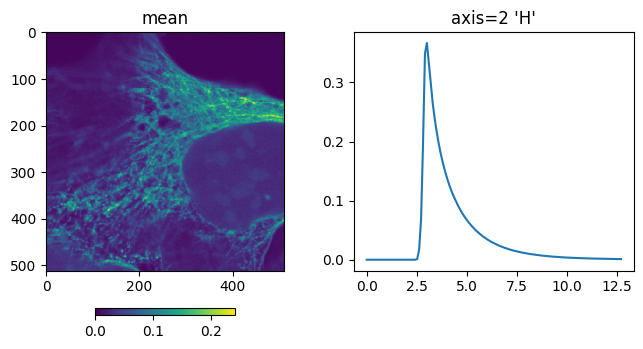

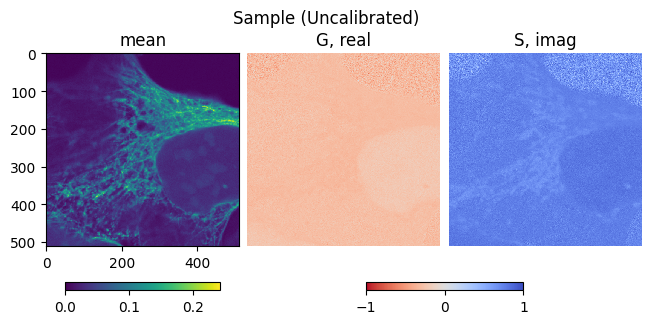

In [8]:
#Visualize the intensity image of the sample (sum over time axis 'H')
plot_signal_image(signal, axis='H')

#Calculate uncalibrated phasors
mean, real, imag = phasor_from_signal(signal, axis='H')

#Visualize the uncalibrated phasor components
plot_phasor_image(mean, real, imag, title='Sample (Uncalibrated)')

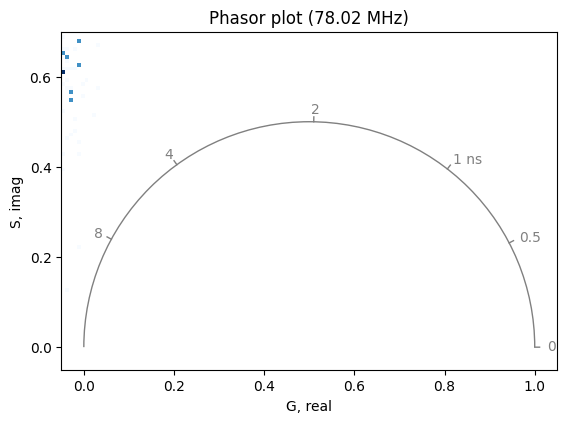

In [9]:
#Quick plot of the phasor cloud
plot_phasor(real, imag, frequency=frequency)

### Calibration
We process the Reference signal (Atto 488, $\tau=4.1$ ns).
1.  Calculate phasors for the reference image.2.  Use phasor_calibrate to calculate the transformation required to move the reference cloud to its theoretical position (4.1 ns on the universal circle).
3.  Apply this transformation to the Sample phasors.

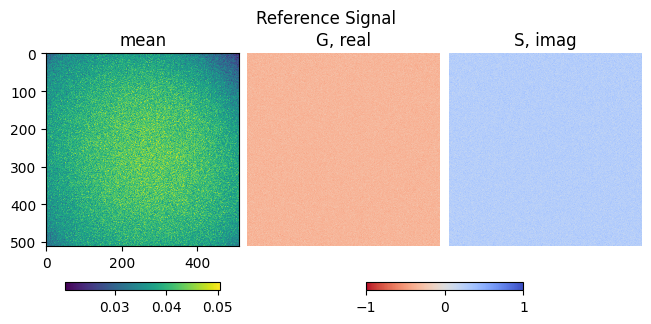

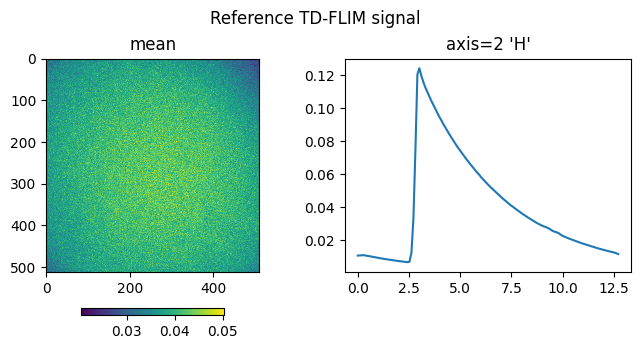

In [10]:
# Process Reference
reference_lifetime = 4.1 # Known lifetime of Atto 488 in ns

img_reference_signal = ref_signal

# Calculate reference phasors
img_reference_mean, img_reference_real, img_reference_imag = phasor_from_signal(img_reference_signal)

# Visualize Reference
plot_phasor_image(img_reference_mean, img_reference_real, img_reference_imag, title='Reference Signal')

plot_signal_image(img_reference_signal, title='Reference TD-FLIM signal')


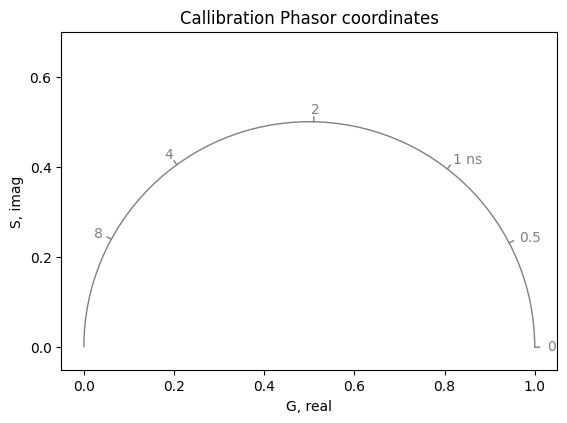

In [11]:
# Plot calibration phasor coordinates generated from synthetic signal
plotty = True
if plotty:
  plot = PhasorPlot(frequency = frequency,
                    title='Callibration Phasor coordinates')
  plot.plot(img_reference_real, img_reference_imag, color = 'b')
  plot.show()

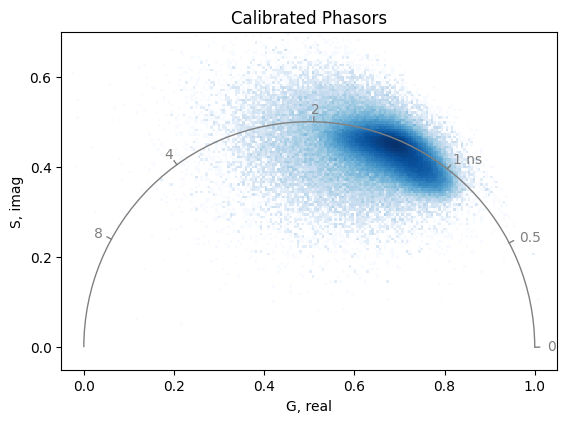

In [12]:
# Apply Calibration phasor_calibrate rotates/scales the 'real' and 'imag' inputs based on the reference
real_cal, imag_cal = phasor_calibrate( real, imag, img_reference_mean, img_reference_real, img_reference_imag, frequency=frequency, lifetime=reference_lifetime )

# Visualize Calibrated Phasor Plot
phasorplot = PhasorPlot(frequency=frequency, title='Calibrated Phasors')
phasorplot.hist2d(real_cal, imag_cal, bins=n_bin)
plt.show()

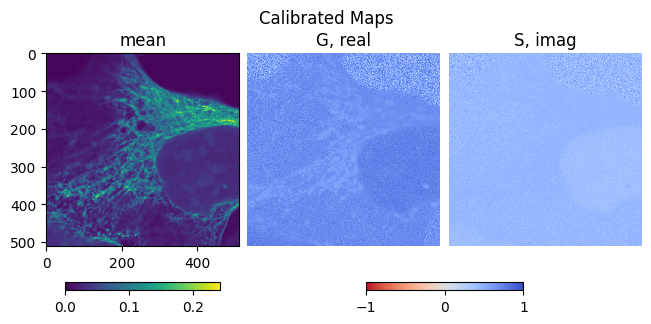

In [13]:
# Visualize Calibrated Components (G and S maps)
plot_phasor_image(mean, real_cal, imag_cal, title="Calibrated Maps")

##Filtering and Standard Thresholding

1.   Median Filtering: We apply a spatial median filter to the $G$ and $S$ maps to reduce salt-and-pepper noise from low photon counts.
2.  Intensity Thresholding: We define a basic mask based on the mean intensity (standard confocal image) to remove background pixels.

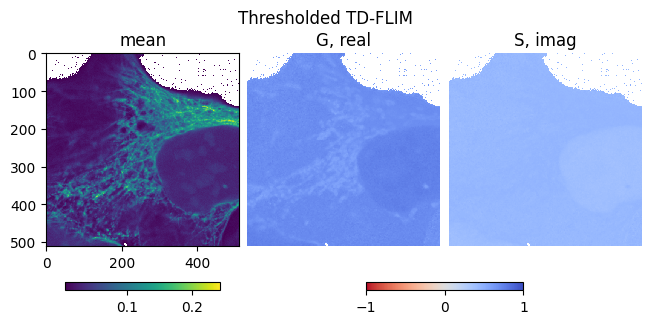

Text(0.5, 1.0, 'Calibrated, filtered phasor coordinates')

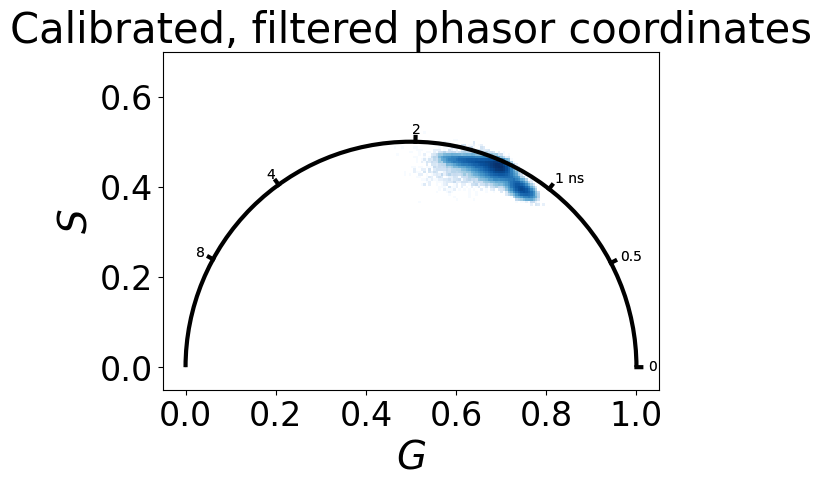

In [14]:
## Median Filtering
#Filters the phasor components (G and S) using a 3x3 (default) kernel
#This improves cluster tightness by averaging neighbors
mean_mf, real_mf, imag_mf = phasor_filter_median(mean, real_cal, imag_cal, size=3, repeat=2)

## Standard Intensity Thresholding
# Create a mask where intensity > mean_min
mean_thresholded, real_thresholded, imag_thresholded = phasor_threshold(mean_mf, real_mf, imag_mf, mean_min=0.0052) # Arbitrary threshold (adjust based on data) )

plot_phasor_image(mean_thresholded, real_thresholded, imag_thresholded, title='Thresholded TD-FLIM')

# Visualize Result
phasorplot = PhasorPlot(frequency=frequency, title='Filtered & Thresholded Phasors')
phasorplot.hist2d(real_thresholded, imag_thresholded, bins = n_bin)
phasorplot.semicircle(frequency, linewidth= lw, color = sc_color)

#Formatting
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Calibrated, filtered phasor coordinates', fontsize = fontsize)


Text(0.5, 1.0, 'Calibrated,\nfiltered phasor coordinates')

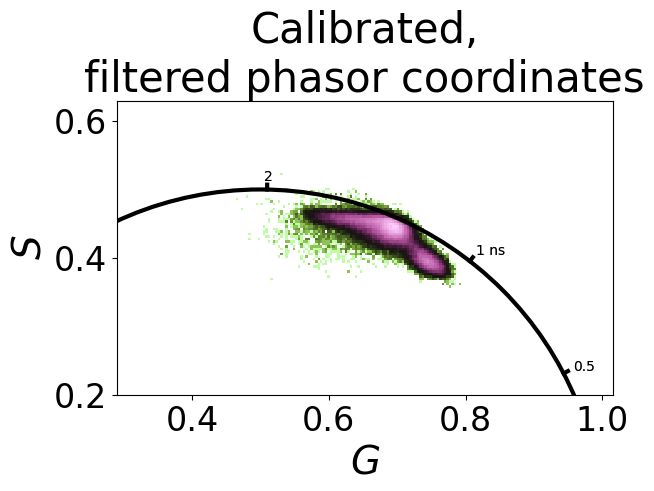

In [15]:
## Zoom to the phasor plot
phasorplot = PhasorPlot( xlim=xlim, ylim=ylim,frequency=frequency)
phasorplot.hist2d(real_thresholded, imag_thresholded, bins = n_bin, cmap= cmap_ph)
phasorplot.semicircle(frequency, linewidth= lw, color = sc_color)

plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Calibrated,\nfiltered phasor coordinates', fontsize = fontsize)

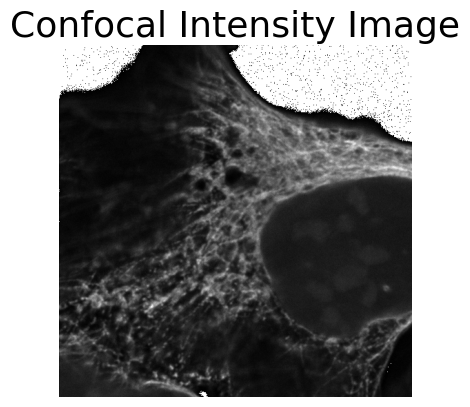

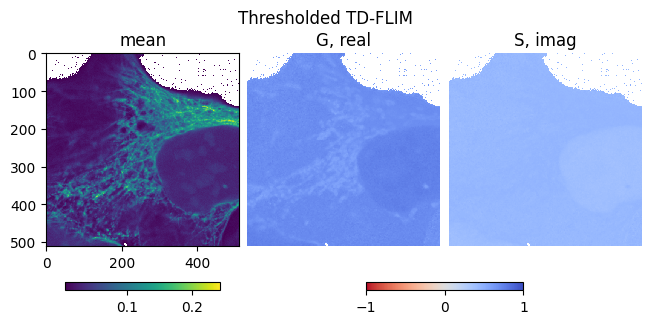

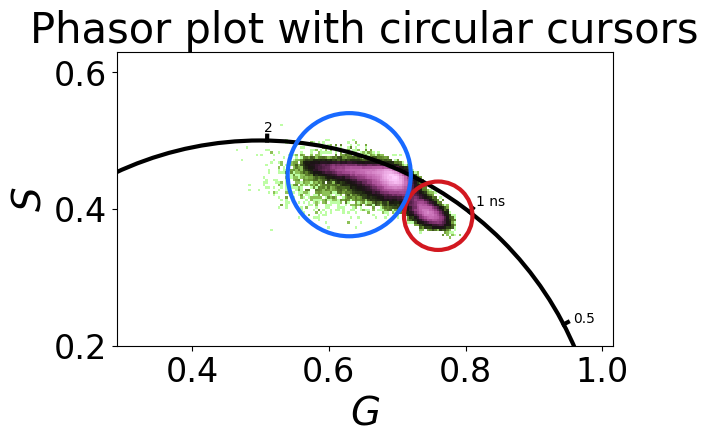

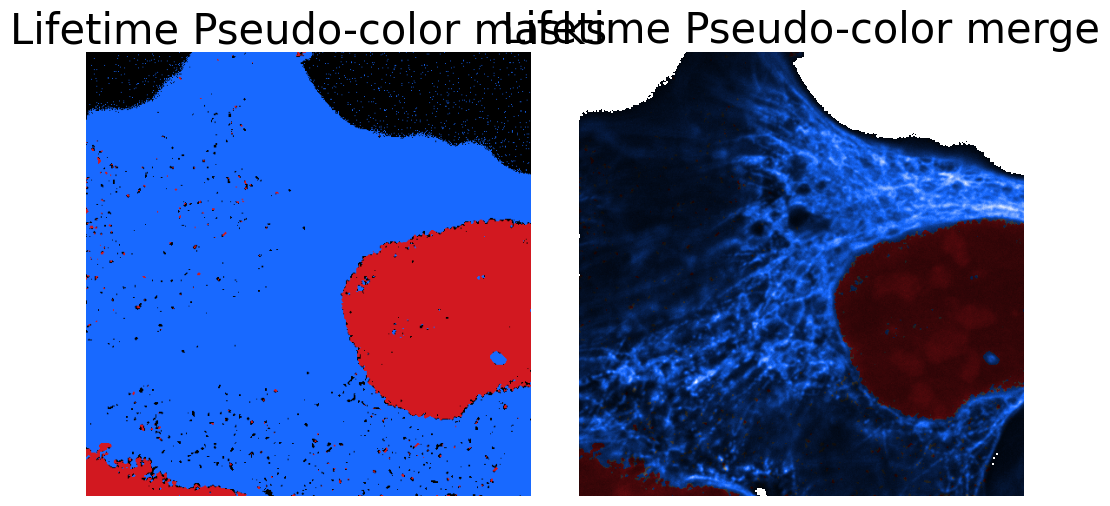

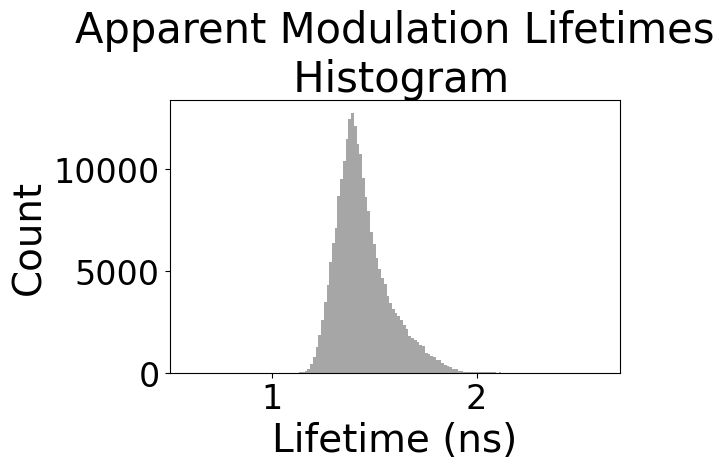

In [16]:
# Visualize with 2 cursors
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mean_thresholded, cmap= intensity)
plt.title("Confocal Intensity Image", fontsize = fontsize -4)
plt.axis('off')

# Assigning cursors
cursors_real = [0.76, 0.63]
cursors_imag = [0.39, 0.45]
radius = [0.05, 0.09]

circular_mask = mask_from_circular_cursor(
    real_thresholded, imag_thresholded, cursors_real, cursors_imag, radius=radius
)

########## Plot

plot_phasor_image(mean_thresholded, real_thresholded, imag_thresholded, title='Thresholded TD-FLIM')

plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False, title='Circular cursors')
plot.semicircle(frequency, linewidth= lw, color = sc_color)
plot.hist2d(real_thresholded, imag_thresholded, cmap= cmap_ph, bins = n_bin)

for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i],
        linestyle='-', linewidth = lw_cursor
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Phasor plot with circular cursors', fontsize = fontsize)
plot.show()

#### Pseudo-color maps

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_thresholded, colors=CATEGORICAL[:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Lifetime Pseudo-color masks', fontsize = fontsize)
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Lifetime Pseudo-color merge', fontsize = fontsize)
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar_width = 55.5  # in pixels
scalebar_height = 8  # in pixels
bar_color = 'white'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos = 530
y_pos = 470

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

#### Histograms

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_thresholded, imag_thresholded, frequency
)

plot_histograms(
    modulation_lifetime,
    range=(0.6, 2.6),
    bins=150,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize
)

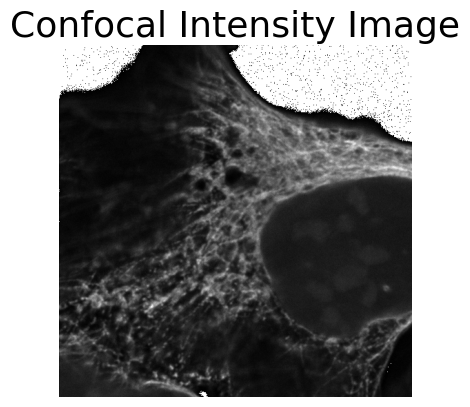

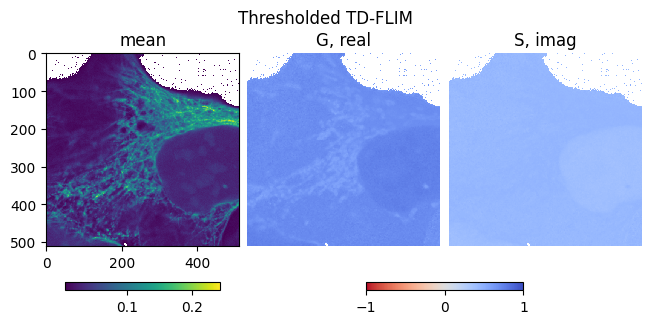

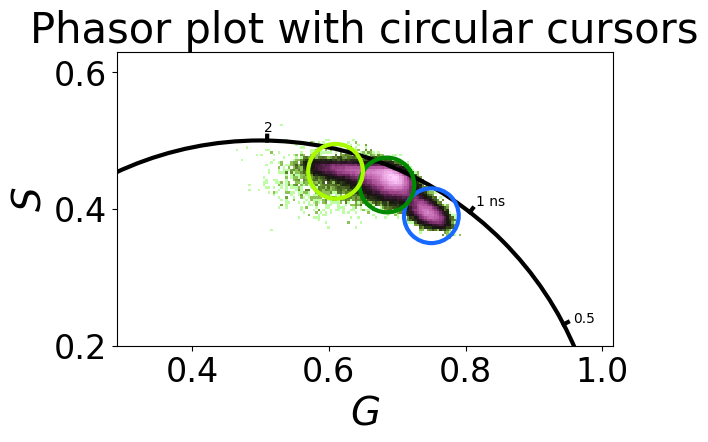

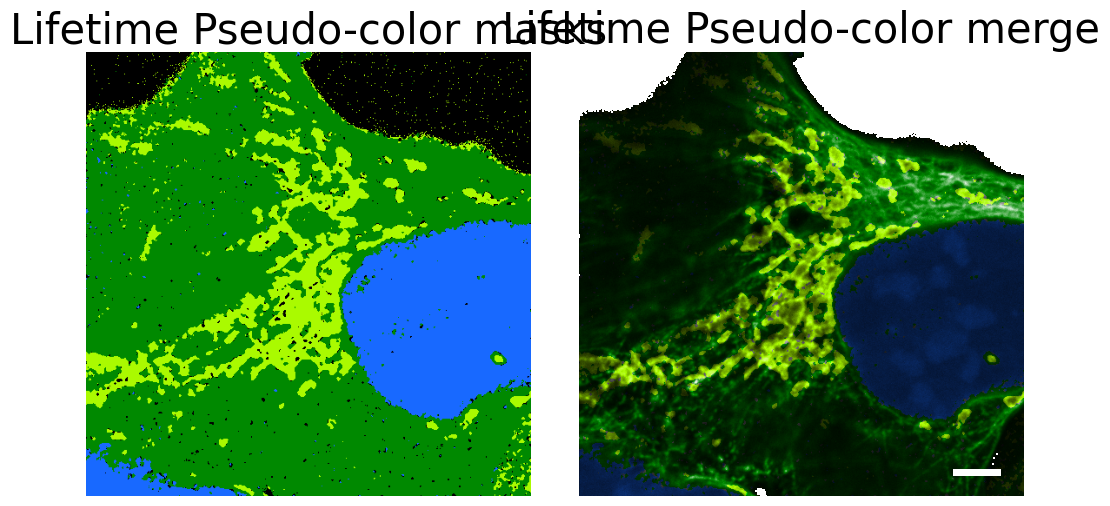

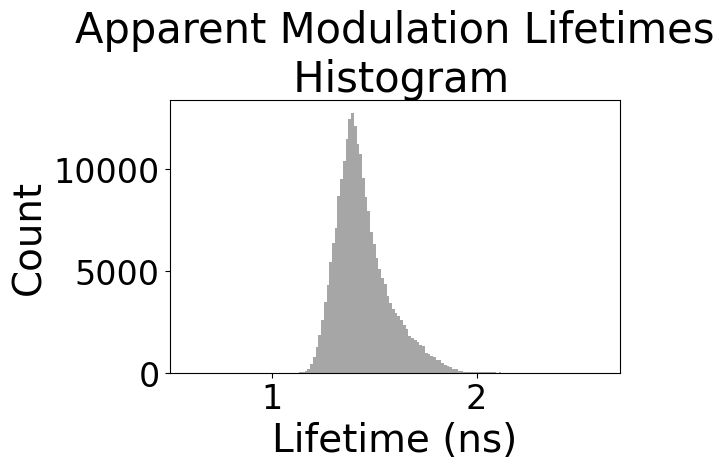

In [17]:
# Visualize with 3 cursors
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mean_thresholded, cmap=intensity)
plt.title("Confocal Intensity Image", fontsize = fontsize -4)
plt.axis('off')

# Assigning cursors
# when using i+1 in CATEGORICAL:
#cursor colors   blue, green, pink, purple, yellow, cyan, ora, brown, darkblue
#components     [DAPI, AF555,    NA,   NA, AF532]
cursors_real =  [0.75, 0.685,   0.01, 0.01,  0.61]
cursors_imag =  [0.39, 0.435, 0.01, 0.01,  0.455]
radius       =  [0.04, 0.04,   0.01, 0.01,  0.04]

circular_mask = mask_from_circular_cursor(
    real_thresholded, imag_thresholded, cursors_real, cursors_imag, radius=radius
)

########## Plot

plot_phasor_image(mean_thresholded, real_thresholded, imag_thresholded, title='Thresholded TD-FLIM')

plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False, title='Circular cursors')
plot.semicircle(frequency=frequency, linewidth= lw, color = sc_color)
plot.hist2d(real_thresholded, imag_thresholded, cmap=cmap_ph, bins = n_bin)
#for i in range(len(cursors_real)):                  #Uncomment to draw polar crosses inside circular cursors
    #plot.cursor(
        #cursors_real[i],
        #cursors_imag[i],
        #radius=radius[i],
        #crosshair=True,
        #polar=True,
        #color=CATEGORICAL[i+2],
        #linestyle='-', linewidth = lw
    #)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw_cursor
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Phasor plot with circular cursors', fontsize = fontsize)
plot.show()

#### Pseudo-color maps

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_thresholded, colors=CATEGORICAL[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Lifetime Pseudo-color masks', fontsize = fontsize)
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Lifetime Pseudo-color merge', fontsize = fontsize)
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar_width = 55.5  # in pixels (4.4um)
scalebar_height = 8  # in pixels
bar_color = 'white'  # or 'black' depending on your image

# Position: bottom left with a 10-pixel margin
x_pos = 430
y_pos = 480

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

#### Histograms

phase_lifetime, modulation_lifetime = phasor_to_apparent_lifetime(
    real_thresholded, imag_thresholded, frequency
)

plot_histograms(
    modulation_lifetime,
    range=(0.6, 2.6),
    bins=150,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize
)

## Component Analysis
This section focuses on decomposing the phasor signal into known biological or chemical components.
1. Define Components: We define three theoretical components with known lifetimes (e.g., DAPI, AF555, AF532).* DAPI: Short lifetime ($\approx 0.5$ ns)* AF555: Medium lifetime ($\approx 1.33$ ns)* AF532: Long lifetime ($\approx 2.6$ ns)
2. Graphical Analysis:We visualize these components on the phasor plot alongside the experimental data histogram. Lines connecting these components form a "phasor triangle," enclosing all possible mixtures of the three species.
3. Fractional Contribution:we compute the distribution of "fractions" along the lines connecting pairs of components. This tells us, for example, if a pixel is a 50/50 mix of DAPI and AF555.

In [18]:
import math

# Import PhasorPy component analysis tools
from phasorpy.component import ( phasor_component_fit, phasor_component_fraction, phasor_component_graphical, )

np.random.seed(42) # Ensure reproducibility

# Styling for component markers on the plot
component_style = {
    'linestyle': '-',
    'linewidth': lw_plot,
    'marker': 'o',
    'color': tag_color,
    'fontsize': 20,
}

In [19]:
## Define Known Component Lifetimes
# These are the theoretical or measured lifetimes of the pure species expected in the sample
# [DAPI, AF555, AF532]
component_lifetimes = [0.5, 1.33, 2.6]

# Convert lifetimes to Phasor Coordinates (G, S)
component_real, component_imag = phasor_from_lifetime( frequency, component_lifetimes )

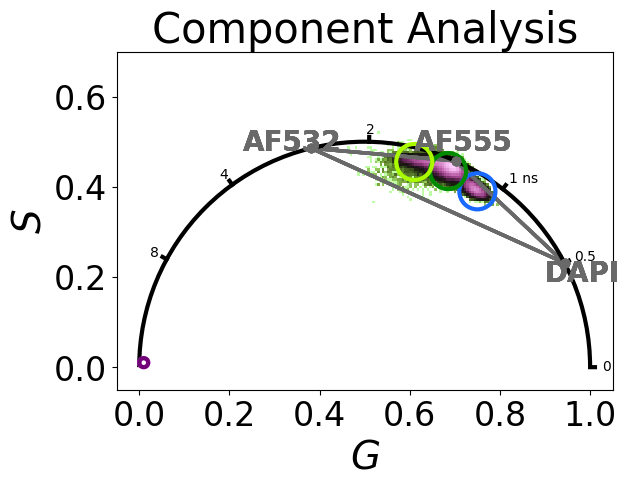

In [20]:
# Initialize Phasor Plot
plot = PhasorPlot(allquadrants=False)
plot.semicircle(frequency=frequency, linewidth=lw, color='black') # Universal Semicircle

# Plot the 2D Histogram of the experimental data (Thresholded)
plot.hist2d(real_thresholded, imag_thresholded, cmap=cmap_ph, bins=n_bin)
for i in range(len(cursors_real)):
  plot.cursor(cursors_real[i],cursors_imag[i],radius=radius[i],color=CATEGORICAL[i+1],linestyle='-', linewidth=lw_cursor)
  #Overlay the Component Markers and connecting lines
  plot.components(component_real, component_imag, labels=['DAPI', 'AF555', 'AF532'], **component_style)
# Formatting
plt.xlabel('$G$', fontsize=labelsize)
plt.ylabel('$S$', fontsize=labelsize)
plt.tick_params(axis='both', labelsize=ticksize)
plt.title('Component Analysis', fontsize=fontsize)

plot.show()

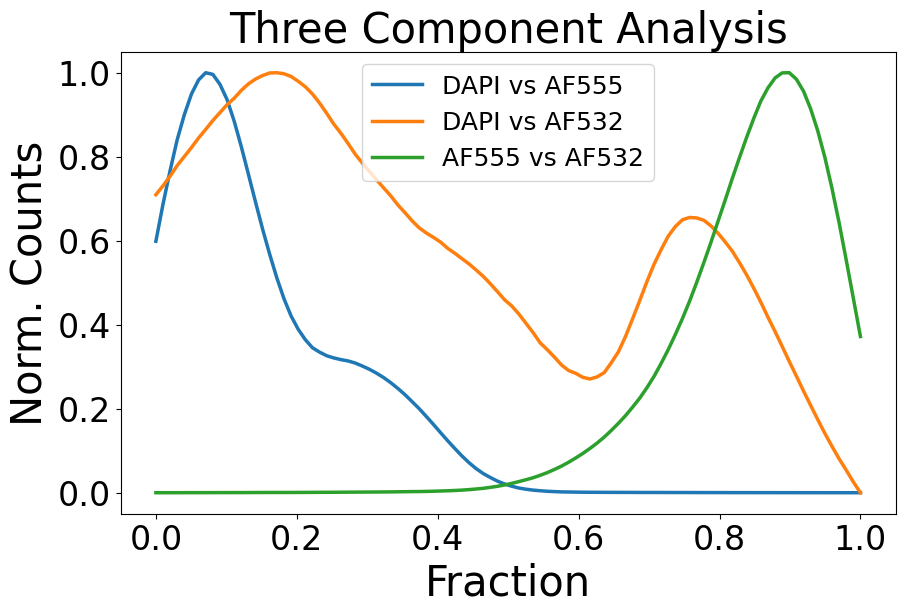

In [21]:
## Graphical Fractional Analysis
# Analysis of how pixels are distributed along the lines connecting the components.
rad = 0.013 # Cursor radius for capturing points along the mixing lines

# Define fractional steps (0% to 100%)
fractions = np.linspace(0.0, 1.0, 100)

# Calculate counts of pixels corresponding to mixtures of component pairs
# Returns a list of arrays:
#counts[0]: Mixture of Component 0 (DAPI) and Component 1 (AF555)
#counts[1]: Mixture of Component 0 (DAPI) and Component 2 (AF532)
#counts[2]: Mixture of Component 1 (AF555) and Component 2 (AF532)
counts = phasor_component_graphical( real_thresholded, imag_thresholded, component_real, component_imag, fractions=fractions, radius=rad,)

# Min-Max Normalization to compare distributions on the same scale
normcounts_0 = (counts[0] - np.min(counts[0])) / (np.max(counts[0]) - np.min(counts[0]))
normcounts_1 = (counts[1] - np.min(counts[1])) / (np.max(counts[1]) - np.min(counts[1]))
normcounts_2 = (counts[2] - np.min(counts[2])) / (np.max(counts[2]) - np.min(counts[2]))

# Plot the mixing distributions
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(fractions, normcounts_0, '-', label='DAPI vs AF555', linewidth=lw_plot)
ax.plot(fractions, normcounts_1, '-', label='DAPI vs AF532', linewidth=lw_plot)
ax.plot(fractions, normcounts_2, '-', label='AF555 vs AF532', linewidth=lw_plot)

# Formatting
ax.set_title('Three Component Analysis', fontsize=fontsize)
ax.set_xlabel('Fraction', fontsize=fontsize)
ax.set_ylabel('Norm. Counts', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=ticksize)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Scientific notation for Y axis ax.legend(fontsize=legendsize)

ax.legend(fontsize = legendsize)

plt.show()

This section applies Mean Shift Super Resolution (MSSR) to the intensity image derived from the FLIM data.

progress: 100%|██████████| 9/9 [00:00<00:00, 19.13it/s]


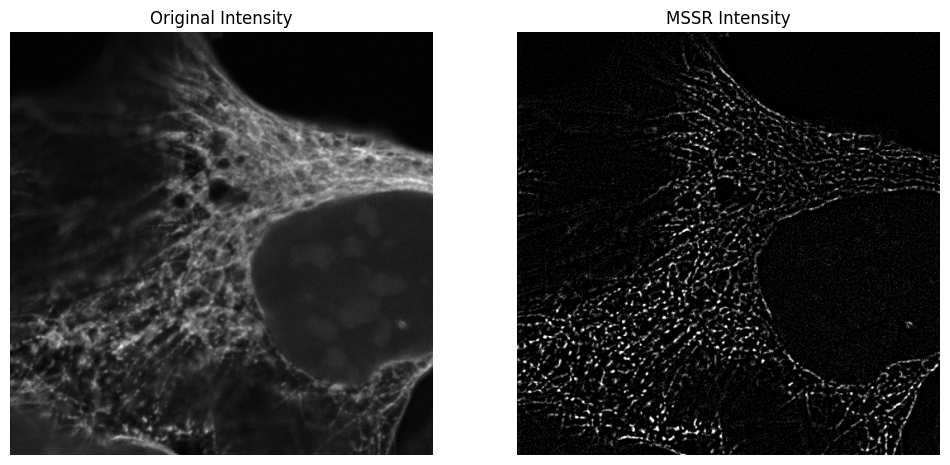

In [22]:
## MSSR Parameters
sigma_px = 3.44
fwhm = 2.35 * sigma_px  # Approximate PSF size in pixels (defines the scale of features to resolve)
amp = 1 # Amplification factor (intensity boosting)
order = 1 # MSSR order (1 is standard; higher orders sharpen more but risk artifacts)
mesh = True  # Optional, default is True
ftI = False  # Optional, default is False
intNorm = False  # Optional, default is True


# Apply MSSR
"""
Process the 'mean' intensity image (sum of photons over time)
mesh=True: Enables mesh-based processing for speed/quality balance
ftI=False: No Fourier Transform interpolation
intNorm=True: Normalizes the output intensity to [0, 1] range
"""
mean_mssr = mssr_instance.sfMSSR( img=mean, fwhm=fwhm, amp=amp, order=order, mesh=mesh, ftI=ftI, intNorm=intNorm)

# Visualization: Original vs. MSSR Intensity
# Compare the standard diffraction-limited image with the MSSR result
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original Intensity
ax[0].imshow(mean, cmap='gray')
ax[0].set_title("Original Intensity")
ax[0].axis('off')

# MSSR Intensity
ax[1].imshow(mean_mssr, cmap='gray', vmin=0, vmax=0.25)
ax[1].set_title("MSSR Intensity")
ax[1].axis('off')

plt.show()

## Re-Thresholding Phasors with MSSR Mask
Now that we have the mean_mssr image, we use it to filter the original, calibrated phasor data (real_cal, imag_cal).

The original phasor plot often contains a "comet tail" or dispersed cloud caused by pixels with low photon counts or spatial mixing at the edges of structures. The MSSR image has sharper edges and suppressed background, so using it as a mask (mean_min threshold) selects only the high-confidence pixels at the center of the emitters.

In [23]:
## Thresholding
mean_th_mssr1, real_th_mssr1, imag_th_mssr1 = phasor_threshold(mean_mssr, real_mf, imag_mf, mean_min=0.03)

#Circular cursor masking
circular_mask = mask_from_circular_cursor(
    real_th_mssr1, imag_th_mssr1, cursors_real, cursors_imag, radius=radius  #the cursor coordinates are defined above
)


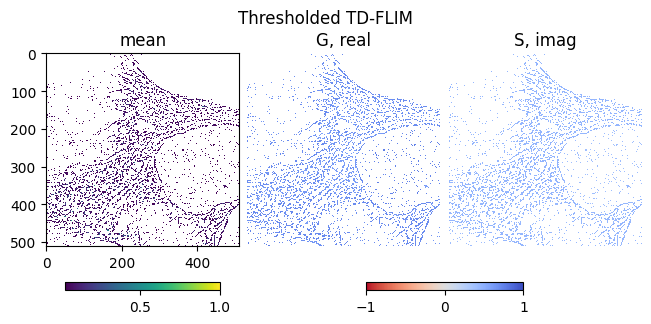

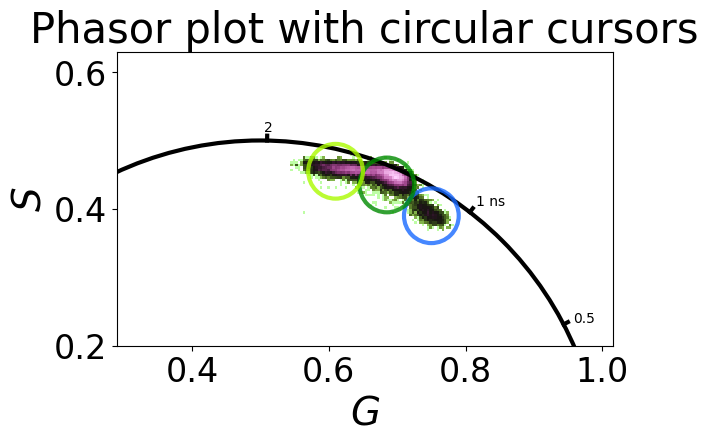

In [24]:
#Plotting

plot_phasor_image(mean_th_mssr1, real_th_mssr1, imag_th_mssr1, title='Thresholded TD-FLIM')

plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False, title='Circular cursors')
plot.semicircle(frequency=frequency, linewidth= lw, color = sc_color)
plot.hist2d(real_th_mssr1, imag_th_mssr1, cmap=cmap_ph, bins = n_bin)
#for i in range(len(cursors_real)):                  #Uncomment to draw polar crosses inside circular cursors
    #plot.cursor(
        #cursors_real[i],
        #cursors_imag[i],
        #radius=radius[i],
        #crosshair=True,
        #polar=True,
        #color=CATEGORICAL[i+2],
        #linestyle='-', linewidth = lw
    #)
for i in range(len(cursors_real)):
    plot.cursor(
        cursors_real[i],
        cursors_imag[i],
        radius=radius[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw_cursor, alpha =0.8
    )
plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', labelsize=ticksize) # Adjust labelsize as needed  which='major'
plt.title('Phasor plot with circular cursors', fontsize = fontsize)
plot.show()


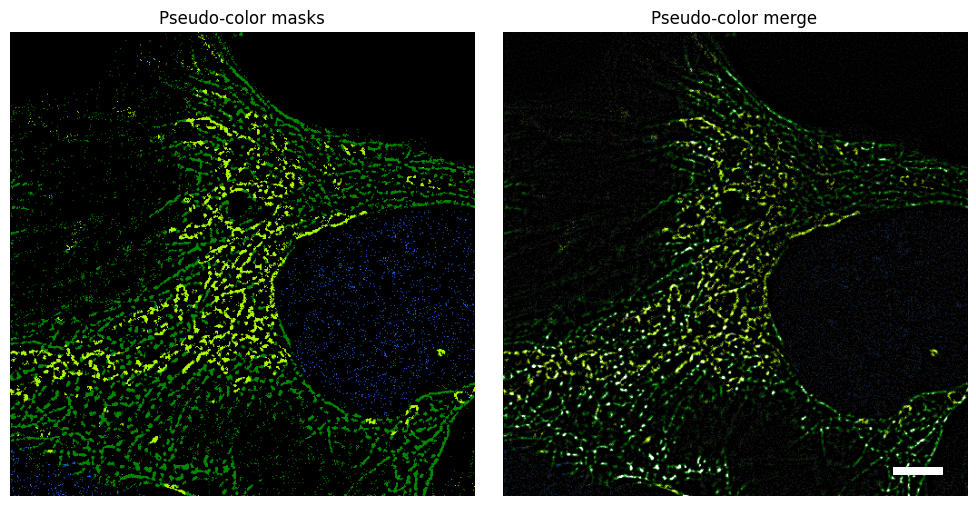

In [25]:
# Apply pseudo color to the intensity image
pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = mean_mssr, colors=CATEGORICAL[1:], vmin=0, vmax=0.25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,
                             linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

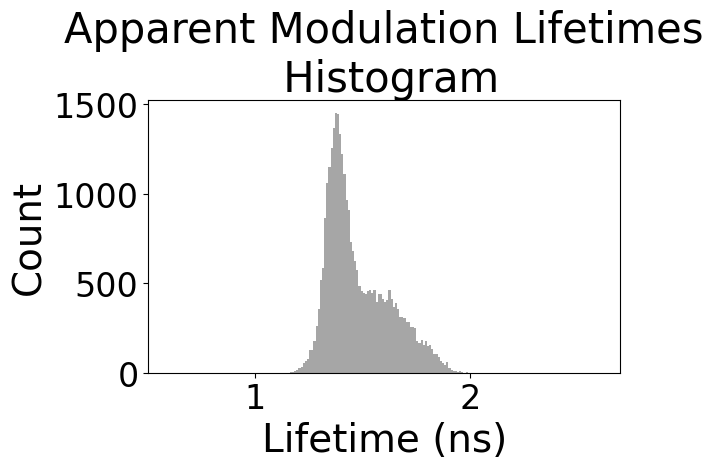

In [26]:
#### Histograms

phase_lt_mssr, mod_lt_mssr = phasor_to_apparent_lifetime(
    real_th_mssr1, imag_th_mssr1, frequency
)

plot_histograms(
    mod_lt_mssr,
    range=(0.6, 2.6),
    bins=200,
    alpha=0.7,
    title='Apparent Modulation Lifetimes\n Histogram',
    xlabel='Lifetime (ns)',
    ylabel='Count',
    color='gray',
    title_fontsize= fontsize,
    label_fontsize = labelsize,
    tick_labelsize = ticksize,
    )

## Phasor Plot with Components (MSSR Enhanced)
This plot provides a comprehensive view of the phasor distribution derived from the MSSR-sharpened image.


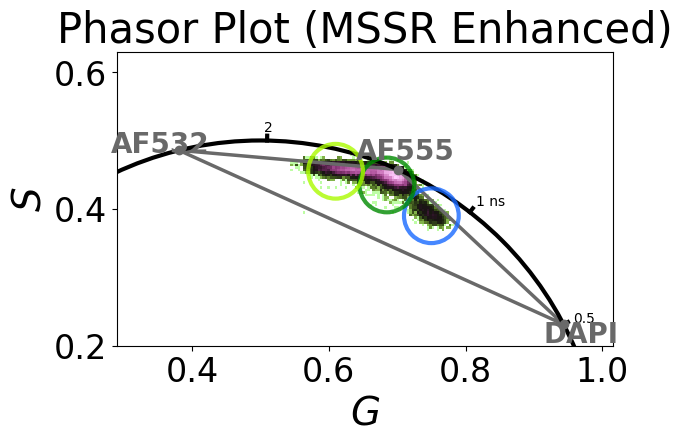

In [27]:
## Define Theoretical Components
# Lifetimes of pure fluorophores expected in the sample (in nanoseconds)[DAPI (~0.5ns), AF555 (~1.33ns), AF532 (~2.6ns)]component_lifetimes = [0.5, 1.33, 2.6]
# Convert lifetimes to Phasor Coordinates (G, S
component_real, component_imag = phasor_from_lifetime(
    frequency, component_lifetimes)

# Initialize Phasor Plot
plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False)
plot.semicircle(frequency=frequency, linewidth=lw, color=sc_color)

# Plot the 2D Histogram of the MSSR-masked phasor data
plot.hist2d(real_th_mssr1, imag_th_mssr1, cmap=cmap_ph, bins=n_bin)

## Overlay Cursors
#Loop through defined cursors (ROIs) and draw them on the plot
for i in range(len(cursors_real)):
  plot.cursor(
      cursors_real[i],
      cursors_imag[i],
      radius=radius[i],
      color=CATEGORICAL[i+1],    # Assign distinct colors
      linestyle='-',linewidth=lw_cursor,alpha=0.8
              )

## Overlay Component Markers ---Mark the theoretical positions of DAPI, AF555, and AF532Connecting lines (if style includes them) help visualize mixing pathway
plot.components(
    component_real,component_imag,labels=['DAPI', 'AF555', 'AF532'],**component_style)

# Formatting
plt.xlabel('$G$', fontsize=labelsize)
plt.ylabel('$S$', fontsize=labelsize)
plt.tick_params(axis='both', labelsize=ticksize)
plt.title('Phasor Plot (MSSR Enhanced)', fontsize=fontsize) # Added title for clarityDisplay the final plot
plot.show()

## Fractional Component Analysis

Having visualized the components on the phasor plot, we now quantify the mixture for every pixel.

We applied the phasor_component_graphical function to project the experimental phasor data onto the lines connecting our theoretical components.
* This calculates a "fraction" (0 to 1) for each pixel, representing its position along the mixing line between two species (e.g., 0 = Pure DAPI, 1 = Pure AF555).
* We perform this for all three pairwise combinations: DAPI-AF555, DAPI-AF532, and AF555-AF532.

The result is a set of histograms showing the distribution of these fractions. Peaks in these histograms reveal the dominant populations or mixing states present in the sample.

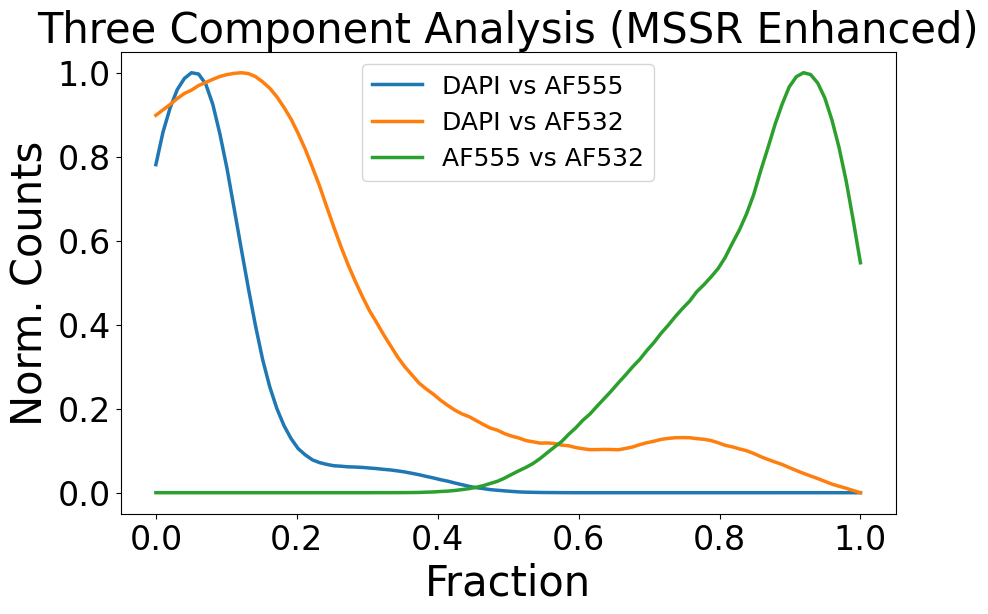

In [28]:
## Define Analysis Parameters
rad = 0.013 # Cursor radius for capturing points along the mixing lines (tolerance)

# Define fractional steps (0% to 100%)
fractions = np.linspace(0.0, 1.0, 100)

## Calculate Component Fractions
# This function analyzes the distribution of pixels along the lines connecting component pairs.
# It returns the counts (histogram) of pixels at each fractional step.

counts = phasor_component_graphical(
    real_th_mssr1,
    imag_th_mssr1,
    component_real,
    component_imag,
    fractions=fractions,
    radius=rad,)
# counts[0]: Mixture of Component 0 (DAPI) and Component 1 (AF555)
# counts[1]: Mixture of Component 0 (DAPI) and Component 2 (AF532)
# counts[2]: Mixture of Component 1 (AF555) and Component 2 (AF532)

## Normalization
# Min-Max normalization scales the counts to [0, 1] for easier visual comparison between pairs
normcountsmssr_0 = (counts[0] - np.min(counts[0])) / (np.max(counts[0]) - np.min(counts[0]))
normcountsmssr_1 = (counts[1] - np.min(counts[1])) / (np.max(counts[1]) - np.min(counts[1]))
normcountsmssr_2 = (counts[2] - np.min(counts[2])) / (np.max(counts[2]) - np.min(counts[2]))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the normalized mixing distributions
ax.plot(fractions, normcountsmssr_0, '-', label='DAPI vs AF555', linewidth=lw_plot)
ax.plot(fractions, normcountsmssr_1, '-', label='DAPI vs AF532', linewidth=lw_plot)
ax.plot(fractions, normcountsmssr_2, '-', label='AF555 vs AF532', linewidth=lw_plot)

# Formatting
ax.set_title('Three Component Analysis (MSSR Enhanced)', fontsize=fontsize)
ax.set_xlabel('Fraction', fontsize=fontsize)
ax.set_ylabel('Norm. Counts', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=ticksize)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Scientific notation for Y axis
ax.legend(fontsize=legendsize)

plt.show()

## Comparative Component Analysis

This figure overlays the fractional distributions derived from the Standard intensity mask (dashed lines) and the MSSR-enhanced mask (solid lines).

To visualize how the super-resolution processing affects the quantification of mixed species.

A vertical purple line is drawn at 0.5 (50%). If MSSR improves separation, we might expect the solid lines to show sharper peaks near 0 or 1 (pure species) or distinct shifts compared to the broader distributions of the standard data.

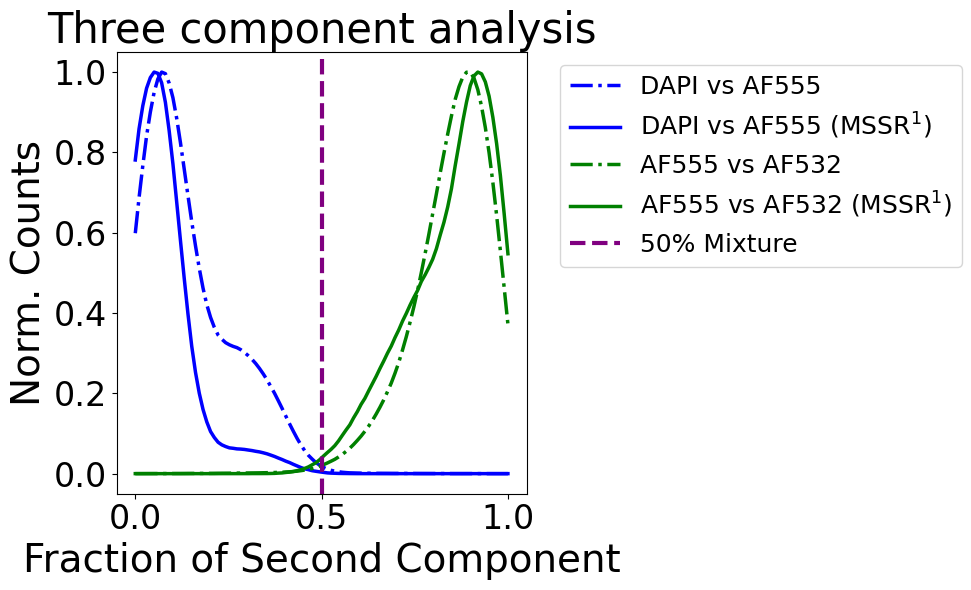

In [29]:
"""
Data Definition (implied from previous calculations)
counts[0] / normcounts_0: DAPI vs AF555
counts[1] / normcounts_1: DAPI vs AF532
counts[2] / normcounts_2: AF555 vs AF532
"""
## Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot DAPI vs AF555 (Blue)
ax.plot(fractions, normcounts_0, label='DAPI vs AF555', linewidth=lw_plot, linestyle='dashdot', color='b')
# MSSR (Solid)
ax.plot(fractions, normcountsmssr_0, label='DAPI vs AF555 (MSSR$^1$)', linewidth=lw_plot, color='b')

# Plot DAPI vs AF532 (Yellow) - Currently Commented Out
#ax.plot(fractions, normcounts_1, label='DAPI vs AF532', linewidth=lw_plot, linestyle='dashdot', color='y')
#ax.plot(fractions, normcountsmssr_1, label='DAPI vs AF532 (MSSR$^1$)', linewidth=lw_plot, color='y')

# Plot AF555 vs AF532 (Green)
ax.plot(fractions, normcounts_2, label='AF555 vs AF532', linewidth=lw_plot, linestyle='dashdot', color='g')
# MSSR (Solid)
ax.plot(fractions, normcountsmssr_2, label='AF555 vs AF532 (MSSR$^1$)', linewidth=lw_plot, color='g')

## Formatting
ax.set_title('Three component analysis', fontsize=fontsize)
ax.set_xlabel('Fraction of Second Component', fontsize=labelsize)
ax.set_ylabel('Norm. Counts', fontsize=labelsize)

ax.tick_params(axis='both', labelsize=ticksize)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Scientific notation

# Reference Line at 50% mixture
ax.axvline(0.5, linestyle='--', linewidth=lw, color='purple', label='50% Mixture')


ax.legend(fontsize=legendsize, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout() # Adjust layout to ensure the external legend is not clipped plt.show()

## Quantitative Metrics: Phasor & Component Improvement

This section aggregates the statistical results to quantify the enhancement provided by MSSR. We evaluate improvement in two distinct domains:
1. Phasor Metrics (Cluster Quality): We compare the geometric properties of the phasor cloud before (real_th, imag_th) and after (real_th_mssr1, imag_th_mssr1) MSSR thresholding.
Key Metric: Area Ratio. A value < 1.0 indicates
the cluster has tightened, implying better precision.
2. Fraction Metrics (Component Separation):
We compare the distribution of mixing fractions for a specific component pair (here, DAPI vs. AF532).

In [30]:
## Define Data for Comparison
# Phasor Coordinates (Before = Standard, After = MSSR)
G_before = real_thresholded
S_before = imag_thresholded
G_after = real_th_mssr1
S_after = imag_th_mssr1

# Component Fraction Distributions (normalized counts)
"""
Recall:
normcounts_0 = DAPI vs AF555
normcounts_1 = DAPI vs AF532 (Selected for analysis below)
normcounts_2 = AF555 vs AF532
"""
before = normcounts_1 # Standard distribution for DAPI-AF532 mixing after = normcountsmssr_1 # MSSR distribution for DAPI-AF532 mixing
after = normcountsmssr_1

## Calculate Phasor Cluster Metrics
# Computes Centroid Shift, Ellipse Area, and Area Ratio (Shrinkage)
phasor_metrics = compute_phasor_metrics(G_before, S_before, G_after, S_after)

# Calculate Fraction Distribution Metrics
# Computes statistics comparing the shapes of the two histograms (e.g., Divergence, Overlap)
fraction_metrics = compute_fraction_metrics(fractions, before, after)


--- Phasor Metrics ---
n_points_before          : 231482
n_points_after           : 31461
centroid_before          : (0.6889, 0.4363)
centroid_after           : (0.6735, 0.4485)
centroid_displacement    :  0.0196
ellipse_area_before      :  0.0104
ellipse_area_after       :  0.0086
area_ratio               :  0.8259
anisotropy_before        :  3.3074
anisotropy_after         :  3.6173
anisotropy_ratio         :  1.0937
covariance_before        : [[ 0.00149012 -0.00066385]
 [-0.00066385  0.00049965]]
covariance_after         : [[ 0.00153142 -0.00040265]
 [-0.00040265  0.0002412 ]]
sigma_GS_before          : -0.0007
sigma_GS_after           : -0.0004
orientation_before_deg   : -26.6385
orientation_after_deg    : -15.9853
orientation_change_deg   :  10.6532

--- Fraction Metrics ---
variance_before     :  2.001878e-05
variance_after      :  9.783088e-05
overlap_coefficient :  7.322877e-01
JSD                 :  4.592161e-02
f_star_before       :  8.888889e-01
f_star_after        :  2.424

## Analysis of ROIs (Region of Interest)

In this step, we manually define and extract specific sub-regions (ROIs) from the full image.
This allows us to analyze the phasor distribution of individual structures or clusters separately, rather than averaging over the entire image.

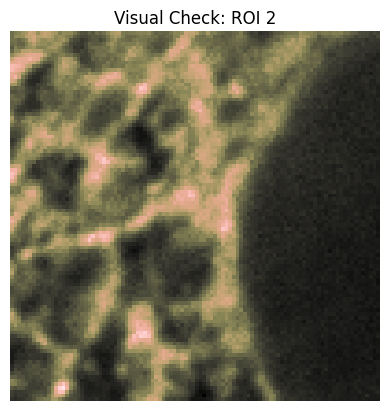

In [31]:
## ROIs selection
# Define ROI slices coordinates (y, x)
# Format: image[row_start : row_end, col_start : col_end]

# ROI 1
# Coords: rows 165:265, cols 305:405
roi1_mean_th = mean_thresholded[165:265, 305:405] # Intensity image
roi1_real_th = real_thresholded[165:265, 305:405] # G map (Real)
roi1_imag_th = imag_thresholded[165:265, 305:405] # S map (Imaginary)

# ROI 2
# Commented coords: rows 190:290, cols 220:320
roi2_mean_th = mean_thresholded[230:330, 230:330] # Intensity image
roi2_real_th = real_thresholded[230:330, 230:330] # G map
roi2_imag_th = imag_thresholded[230:330, 230:330] # S map

# ROI 3
# Commented coords: rows 340:440, cols 385:485
roi3_mean_th = mean_thresholded[340:440, 385:485] # Intensity image
roi3_real_th = real_thresholded[340:440, 385:485] # G map
roi3_imag_th = imag_thresholded[340:440, 385:485] # S map

# ROI 4
# Commented coords: rows 300:400, cols 230:330
roi4_mean_th = mean_thresholded[300:400, 230:330] # Intensity image
roi4_real_th = real_thresholded[300:400, 230:330] # G map
roi4_imag_th = imag_thresholded[300:400, 230:330] # S map

## Visualization
plt.imshow(roi2_mean_th, cmap='cmc.turku')
plt.title("Visual Check: ROI 2")
plt.axis('off') # Optional: hide axis for cleaner view
plt.show()

## Phasor Analysis of Selected ROI
After extracting the Regions of Interest (ROIs), we analyze one specific ROI in detail (e.g., ROI 1).

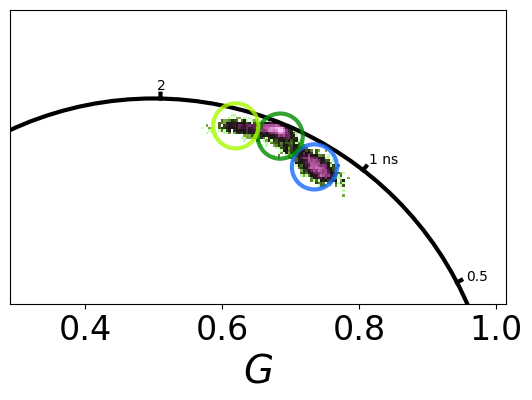

In [32]:
# Phasors from ROIs -----1.
# Select ROI for Analysis
roi = 1

#Assign ROI 1 data to generic variables for processing
#Change 'roi1_...' to 'roi2_...' etc. to analyze other regions
mean_th_zoom = roi1_mean_th
real_th_zoom = roi1_real_th
imag_th_zoom = roi1_imag_th
intensity = mean_th_zoom

# Define Cursor Coordinates for ROIs
# Reference Coordinates (from comments):
#ROI1_real [0.735, 0.685, 0.01,0.01, 0.62]
#ROI1_imag [0.4, 0.445, 0.01, 0.01, 0.46]
#ROI1_radii [0.033, 0.033, 0.01, 0.01, 0.033]
#ROI2_real [0.73, 0.675, 0.01,  0.01,  0.605]
#ROI2_imag [0.405, 0.445, 0.01,  0.01,  0.46]
#ROI2_radii [0.035, 0.035, 0.01,  0.01, 0.035]
#ROI3_real [0.75, 0.69, 0.01,  0.01,  0.615]
#ROI3_imag [0.39, 0.44, 0.01,  0.01,  0.455]
#ROI3_radii [0.04, 0.04, 0.01,  0.01, 0.04]
#ROI4_real [0.75, 0.69, 0.01,  0.01,  0.615]
#ROI4_imag [0.39, 0.44, 0.01,  0.01,  0.455]
#ROI4_radii [0.04, 0.04, 0.01,  0.01, 0.04]

#Parameters for scale bar (Change according to the size of the image analyzed)
scalebar_width = 10  # in pixels (79nm/px)
scalebar_height = 2

# Position: bottom left with a 10-pixel margin
x_pos = 85
y_pos = 90
bar_color = 'white'  # or 'black' depending on your image

#components     [DAPI, AF555,    NA,   NA, AF532]
#cursor colors  blue, green, pink, purple, yellow, cyan, ora, brown, darkblue
cursors_real_roi = [0.735, 0.685, 0.01, 0.01, 0.62]
cursors_imag_roi = [0.4, 0.445, 0.01, 0.01, 0.46]
radius_roi = [0.033, 0.033, 0.01, 0.01, 0.033]

## Generate Masks
# Creates a boolean mask for each cursor (True if pixel falls inside cursor)

circular_mask = mask_from_circular_cursor(
    real_th_zoom, imag_th_zoom, cursors_real_roi, cursors_imag_roi, radius=radius_roi
)

# Plot Phasor Histogram with Cursors
plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False, title='Phasor Plot (ROI)')
plot.semicircle(frequency, linewidth=lw, color=sc_color) # Reference semicircle
plot.hist2d(real_th_zoom, imag_th_zoom, cmap=cmap_ph, bins = n_bin)

# Overlay Cursors
for i in range(len(cursors_real_roi)):
    plot.cursor(
        cursors_real_roi[i],
        cursors_imag_roi[i],
        radius=radius_roi[i],
        color=CATEGORICAL[i+1],
        linestyle='-', linewidth = lw_cursor, alpha = 0.8
    )

plt.xlabel('$G$',fontsize = labelsize)
plt.ylabel('$S$',fontsize = labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize) # Adjust labelsize as needed
plt.title('', fontsize = fontsize)
plot.ax.yaxis.set_visible(False)
plot.show()

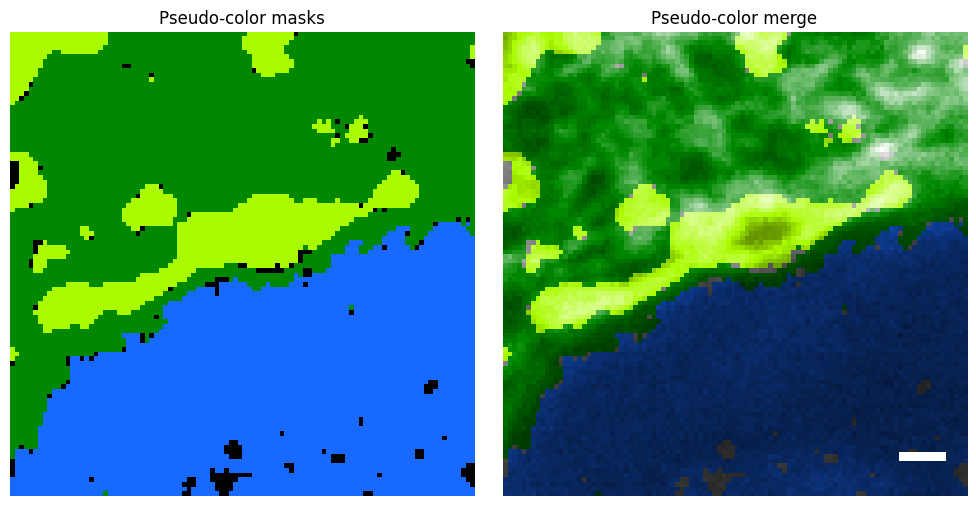

In [33]:
## Generate Pseudo-Color Images
#'masks': Pure colors on black background
#'merge': Colors weighted by intensity (brightness)

pseudo_color_masks = pseudo_color(*circular_mask, intensity = None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity = intensity, colors=CATEGORICAL[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

ax1.set_title('Pseudo-color masks')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')

ax2.set_title('Pseudo-color merge')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')

# Add the scale bar
scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height, linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)

plt.tight_layout()
plt.show()

## Sharpen ROIs with MSSR

Having isolated specific regions of interest (ROIs), we now apply Mean Shift Super Resolution (MSSR) locally to these sub-images.


progress: 100%|██████████| 9/9 [00:00<00:00, 139.38it/s]


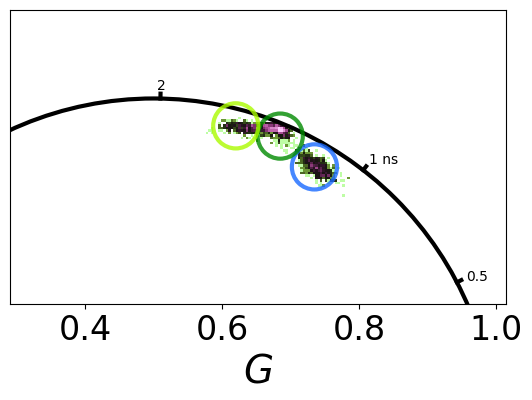

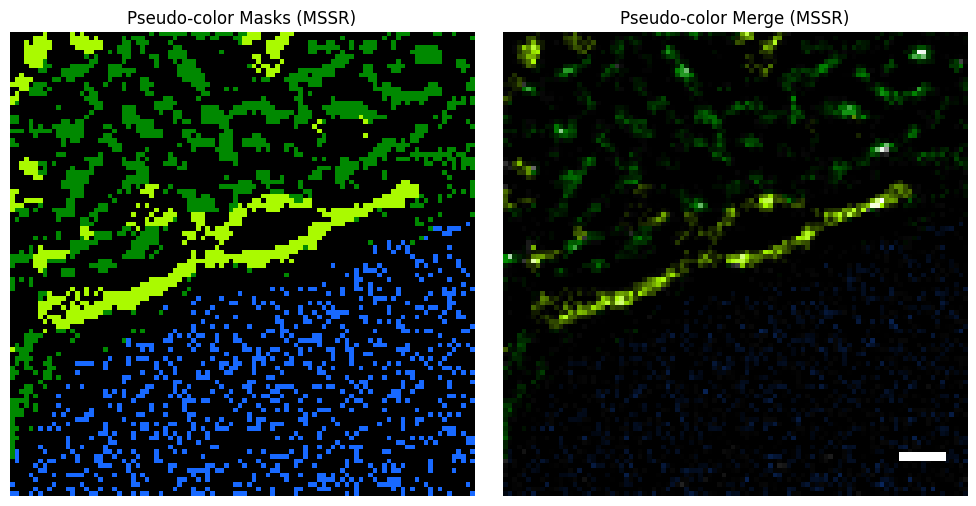

In [35]:
## Apply MSSR to ROI
# Process the zoomed intensity image (ROI) directly.
# Parameters (fwhm, amp, order) are inherited from global settings or previous cells.
mean_zoom_mssr = mssr_instance.sfMSSR(
    mean_th_zoom,
    fwhm=fwhm,
    amp=amp,
    order=order,
    mesh=mesh,ftI=ftI,
    intNorm=intNorm
    )
intensity_roi = mean_zoom_mssr # Use the MSSR image as the new intensity reference
# Optional: Visualize the MSSR intensity for the ROI
# plt.imshow(mean_zoom_mssr, cmap='cmc.turku')

## Threshold Phasors with ROI MSSR Mask
# Filter the ROI phasor data using the new MSSR intensity mask.
mean_th_zoom_mssr, real_th_zoom_mssr, imag_th_zoom_mssr = phasor_threshold(
    mean_zoom_mssr,real_th_zoom,imag_th_zoom,mean_min=0.03)

# Generate Masks for MSSR Data
# Re-apply the circular cursors to the MSSR-filtered phasor data.
circular_mask = mask_from_circular_cursor(
    real_th_zoom_mssr,
    imag_th_zoom_mssr,
    cursors_real_roi,
    cursors_imag_roi,
    radius=radius_roi
    )

## Plot Phasor Histogram (MSSR ROI)
plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False, title='Phasor Plot (ROI + MSSR)')
plot.semicircle(frequency=frequency, linewidth=lw, color=sc_color)

#Plot 2D histogram of the MSSR-filtered ROI data
plot.hist2d(real_th_zoom_mssr, imag_th_zoom_mssr, cmap=cmap_ph, bins=n_bin)

#Overlay Cursors
for i in range(len(cursors_real_roi)):
  plot.cursor(
      cursors_real_roi[i],
      cursors_imag_roi[i],
      radius=radius_roi[i],
      color=CATEGORICAL[i+1],
      linestyle='-',
      linewidth=lw_cursor,
      alpha=0.8
      )
plt.xlabel('$G$', fontsize=labelsize)
plt.ylabel('$S$', fontsize=labelsize)
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.title('', fontsize=fontsize)
plot.ax.yaxis.set_visible(False)
plot.show()

## Pseudo-Color Images (MSSR)
pseudo_color_masks = pseudo_color(*circular_mask, intensity=None, colors=CATEGORICAL[1:])
pseudo_color_merge = pseudo_color(*circular_mask, intensity=intensity_roi, colors=CATEGORICAL[1:])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Pseudo-color Masks (MSSR)')
ax1.imshow(pseudo_color_masks)
ax1.axis('off')
ax2.set_title('Pseudo-color Merge (MSSR)')
ax2.imshow(pseudo_color_merge)
ax2.axis('off')
#Scale Bar parameters
scalebar_width = 10  # 79nm per pixel
scalebar_height = 2
x_pos, y_pos = 85, 90
bar_color = 'white'

scalebar = patches.Rectangle((x_pos, y_pos), scalebar_width, scalebar_height,linewidth=0, edgecolor=None, facecolor=bar_color)
ax2.add_patch(scalebar)
plt.tight_layout()
plt.show()

## 3-Component Analysis of ROIs

We perform 3-Component Analysis specifically on the ROI.
Comparison:
We calculate the mixing fractions for the ROI data in two states:
1. Before MSSR: Using the standard ROI data (real_th_zoom).
2. After MSSR: Using the MSSR-filtered ROI data (real_th_zoom_mssr).
Objective:
Demonstrate that MSSR processing leads to resolved species separation, evidenced by sharper peaks in the fractional distribution plots (closer to 0 or 1) compared to the standard data.


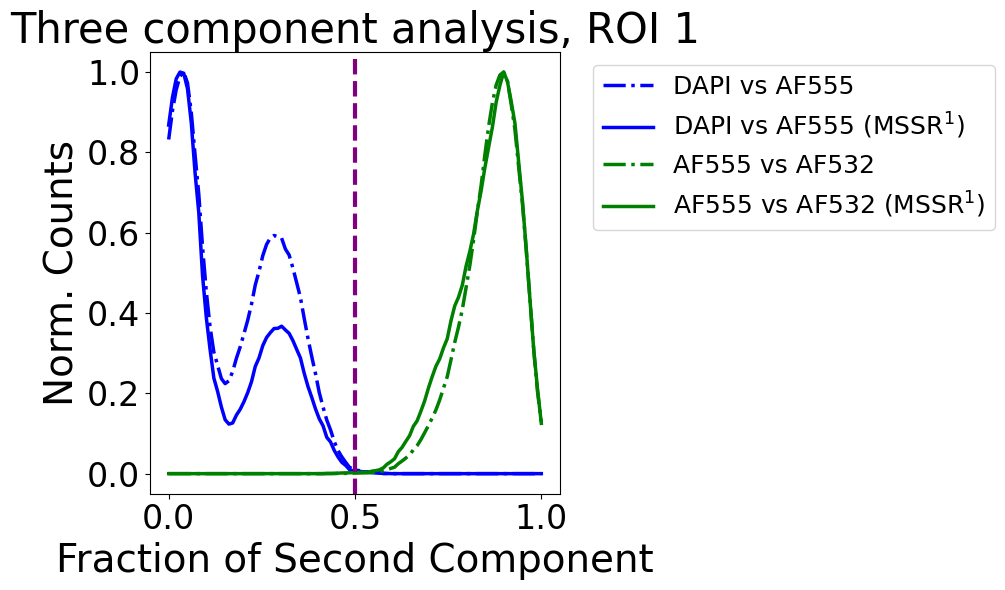

In [38]:
## Parameters
rad = 0.01 # Cursor radius for component lines
fractions = np.linspace(0.0, 1.0, 100) # 0% to 100% steps

## Component Analysis BEFORE MSSR
countszm = phasor_component_graphical(
    real_th_zoom,
    imag_th_zoom,
    component_real,
    component_imag,
    fractions=fractions,
    radius=rad,
    )

# Normalization
normcountszm_0 = (countszm[0] - np.min(countszm[0])) / (np.max(countszm[0]) - np.min(countszm[0]))
normcountszm_1 = (countszm[1] - np.min(countszm[1])) / (np.max(countszm[1]) - np.min(countszm[1]))
normcountszm_2 = (countszm[2] - np.min(countszm[2])) / (np.max(countszm[2]) - np.min(countszm[2]))


## Component Analysis AFTER MSSR
countszmmssr = phasor_component_graphical(
    real_th_zoom_mssr,
    imag_th_zoom_mssr,
    component_real,
    component_imag,
    fractions=fractions,
    radius=rad,
    )

# Normalization (MSSR)
normcountszmmssr_0 = (countszmmssr[0] - np.min(countszmmssr[0])) / (np.max(countszmmssr[0]) - np.min(countszmmssr[0]))
normcountszmmssr_1 = (countszmmssr[1] - np.min(countszmmssr[1])) / (np.max(countszmmssr[1]) - np.min(countszmmssr[1]))
normcountszmmssr_2 = (countszmmssr[2] - np.min(countszmmssr[2])) / (np.max(countszmmssr[2]) - np.min(countszmmssr[2]))


## Comparative Plot (Before vs. After)
fig, ax = plt.subplots(figsize=(10, 6))

#Plot DAPI vs AF555 (Blue)
ax.plot(fractions, normcountszm_0, label='DAPI vs AF555', linewidth=lw_plot, linestyle='dashdot', color='b')
# MSSR (Solid)
ax.plot(fractions, normcountszmmssr_0, label='DAPI vs AF555 (MSSR$^1$)', linewidth=lw_plot, color='b')

# Plot DAPI vs AF532 (Yellow)
#ax.plot(fractions, normcountszm_1, label='DAPI vs AF532', linewidth=lw_plot, linestyle='dashdot', color='y')
#ax.plot(fractions, normcountszmmssr_1, label='DAPI vs AF532 (MSSR$^1$)', linewidth=lw_plot, color='y')

# Plot AF555 vs AF532 (Green)
ax.plot(fractions, normcountszm_2, label='AF555 vs AF532', linewidth=lw_plot, linestyle='dashdot', color='g')
# MSSR (Solid)
ax.plot(fractions, normcountszmmssr_2, label='AF555 vs AF532 (MSSR$^1$)', linewidth=lw_plot, color='g')

# Formatting
ax.set_title(f'Three component analysis, ROI {roi}', fontsize=fontsize)
ax.set_xlabel('Fraction of Second Component', fontsize=labelsize)
ax.set_ylabel('Norm. Counts', fontsize=labelsize)

ax.tick_params(axis='both', labelsize=ticksize)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) # Scientific notation
ax.axvline(0.5, linestyle='--', linewidth=lw, color='purple') # 50% mix line

# Legend outside plot
ax.legend(fontsize=legendsize, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [40]:
## Define Data for Comparison
# Phasor Coordinates (Before = Standard, After = MSSR)
G_before = real_th_zoom
S_before = imag_th_zoom
G_after = real_th_zoom_mssr
S_after = imag_th_zoom_mssr

# Component Fraction Distributions (normalized counts)
"""
Recall:
normcounts_0 = DAPI vs AF555
normcounts_1 = DAPI vs AF532 (Selected for analysis below)
normcounts_2 = AF555 vs AF532
"""
before = normcounts_1 # Standard distribution for DAPI-AF532 mixing after = normcountsmssr_1 # MSSR distribution for DAPI-AF532 mixing
after = normcountsmssr_1

## Calculate Phasor Cluster Metrics
# Computes Centroid Shift, Ellipse Area, and Area Ratio (Shrinkage)
phasor_metrics = compute_phasor_metrics(G_before, S_before, G_after, S_after)

# Calculate Fraction Distribution Metrics
# Computes statistics comparing the shapes of the two histograms (e.g., Divergence, Overlap)
fraction_metrics = compute_fraction_metrics(fractions, before, after)


--- Phasor Metrics ---
n_points_before          : 10000
n_points_after           : 2743
centroid_before          : (0.6987, 0.4307)
centroid_after           : (0.6877, 0.4372)
centroid_displacement    :  0.0128
ellipse_area_before      :  0.0092
ellipse_area_after       :  0.0107
area_ratio               :  1.1694
anisotropy_before        :  4.4767
anisotropy_after         :  4.1129
anisotropy_ratio         :  0.9187
covariance_before        : [[ 0.00153528 -0.000962  ]
 [-0.000962    0.00075782]]
covariance_after         : [[ 0.00174644 -0.00098224]
 [-0.00098224  0.00073881]]
sigma_GS_before          : -0.0010
sigma_GS_after           : -0.0010
orientation_before_deg   : -33.9985
orientation_after_deg    : -31.4228
orientation_change_deg   :  2.5758

--- Fraction Metrics ---
variance_before     :  2.001878e-05
variance_after      :  9.783088e-05
overlap_coefficient :  7.322877e-01
JSD                 :  4.592161e-02
f_star_before       :  8.888889e-01
f_star_after        :  2.424242

## Export Results & Custom Visualization

In [42]:
import tifffile

from google.colab import files # Uncomment if running in Colab
# Save Intensity Image as TIFF

# Select the image to save (e.g., the thresholded mean intensity)
image_to_save = mean_thresholded

#Define output path
output_image_path = "/content/sample_data/3CGQ_Intensity_image.tif"

# Save using tifffile
tifffile.imwrite(output_image_path, image_to_save)
print(f"Image saved to: {output_image_path}")
# Trigger download (Colab specific)
#files.download(output_image_path)

Image saved to: /content/sample_data/3CGQ_Intensity_image.tif


Custom Phasor Plot with Colorbar

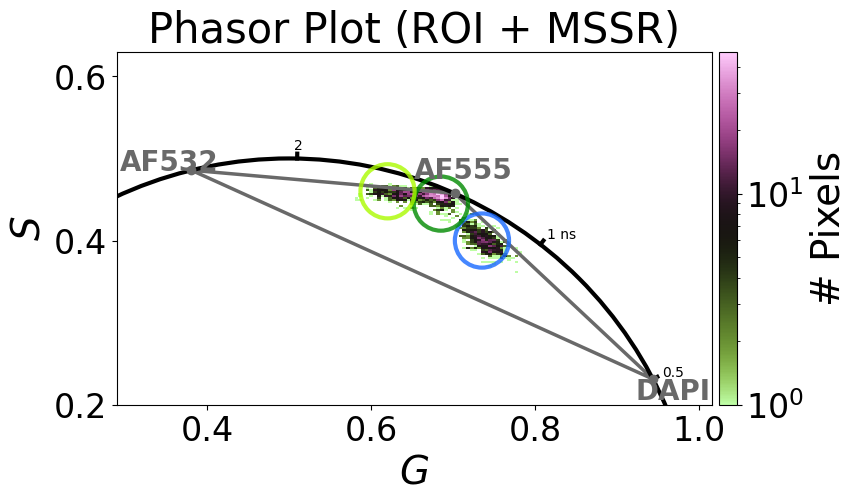

In [44]:
# Choose between Whole Cell vs. ROI, and Standard vs. MSSR
# Current Selection: ROI data AFTER MSSR
data_real = real_th_zoom_mssr
data_imag = imag_th_zoom_mssr
current_cursors_real = cursors_real_roi
current_cursors_imag = cursors_imag_roi
current_radius = radius_roi

# Create figure and main axis
fig, ax = plt.subplots(figsize=(8, 15))

# Initialize PhasorPlot on the specific axis 'ax'
plot = PhasorPlot(xlim=xlim, ylim=ylim, allquadrants=False, ax=ax)
# Draw Universal Semicircle
plot.semicircle(frequency=frequency, linewidth=lw, color=sc_color)

#Plot 2D Histogram using custom method'mappable' captures the image data for the colorbarBins: 75 (Whole Cell), 40-50 (ROIs)
mappable = plot.my_hist2d(data_real,data_imag,cmap=cmap_ph,bins=45)
# Overlay Cursors
for i in range(len(current_cursors_real)):
  plot.cursor(
      current_cursors_real[i],
      current_cursors_imag[i],
      radius=current_radius[i],
      color=CATEGORICAL[i+1],
      linestyle='-',
      linewidth=lw_cursor,
      alpha=0.8
      )
# Overlay Theoretical Components
plot.components(component_real,component_imag,labels=['DAPI', 'AF555', 'AF532'],**component_style)

#Formatting Labels
ax.set_xlabel('$G$', fontsize=labelsize)
ax.set_ylabel('$S$', fontsize=labelsize)
ax.tick_params(axis='both', labelsize=ticksize)
ax.set_title('Phasor Plot (ROI + MSSR)', fontsize=fontsize)

# Attach Aligned Colorbar
# 'make_axes_locatable' ensures the colorbar is exactly the same height as the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.07)  # size=width, pad=spacing

#Create the colorbar in the new axis 'cax'
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label('# Pixels', fontsize=labelsize)
cbar.ax.tick_params(labelsize=ticksize)

#Ensure aspect ratio remains correct
ax.set_aspect('equal', adjustable='box')
plt.show()